# Signal Preprocessing

## Steps
1. Denoising
    - High-frequency noise (> 40 hz).
    - Baseline wander (< 0.5 hz).
2. Inversion correction
    - If the signal is inverted, correct it.
3. Downsampling
    - From 300 hz to 100 hz.

## Load Config

In [1]:
import configparser
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import shutil
import wfdb
import neurokit2 as nk
import numpy as np


config = configparser.ConfigParser()
config.read("config.ini")

label_file = Path(config["data_preprocessing"]["label_file"])
src_dir = Path(config["data_preprocessing"]["src_dir"])
dst_dir = Path(config["data_preprocessing"]["dst_dir"])

src_freq = config["data_preprocessing"].getint("src_freq")
dst_freq = config["data_preprocessing"].getint("dst_freq")

In [2]:
def preprocess_signal(signal, freq, dst_freq):
    # denoising
    signal = nk.signal_filter(
        signal,
        sampling_rate=freq,
        lowcut=0.5,
        highcut=40,
        method="butterworth",
        order=6,
    )

    # inversion correction
    signal, _ = nk.ecg_invert(signal, sampling_rate=freq)

    # downsampling
    signal = nk.signal_resample(
        signal, sampling_rate=freq, desired_sampling_rate=dst_freq
    )

    return signal

In [3]:
# remove existing files and directories
shutil.rmtree(dst_dir, ignore_errors=True)

dst_dir.mkdir(parents=True, exist_ok=True)

# load the dataset
dataset_df = pd.read_csv(label_file, header=None, names=["record_name", "label"])

# load all signals and labels
all_signals: list[np.ndarray] = []
all_labels: list[str] = dataset_df["label"].tolist()
for record_name in tqdm(
    dataset_df["record_name"],
    total=len(dataset_df),
    desc=f"Loading dataset",
):
    # load signal
    signal, _ = wfdb.rdsamp(src_dir / record_name)
    signal = np.squeeze(signal)
    all_signals.append(signal)

# process the dataset
for record_name, label, signal in tqdm(
    zip(dataset_df["record_name"], all_labels, all_signals),
    total=len(all_labels),
    desc=f"Processing dataset",
):
    # preprocess the signal
    preprocessed_signal = preprocess_signal(signal, src_freq, dst_freq)

    np.savetxt(dst_dir / f"{record_name}.csv", preprocessed_signal, fmt="%f")


Processing dataset: 100%|██████████| 8528/8528 [02:02<00:00, 69.51it/s]


## Example

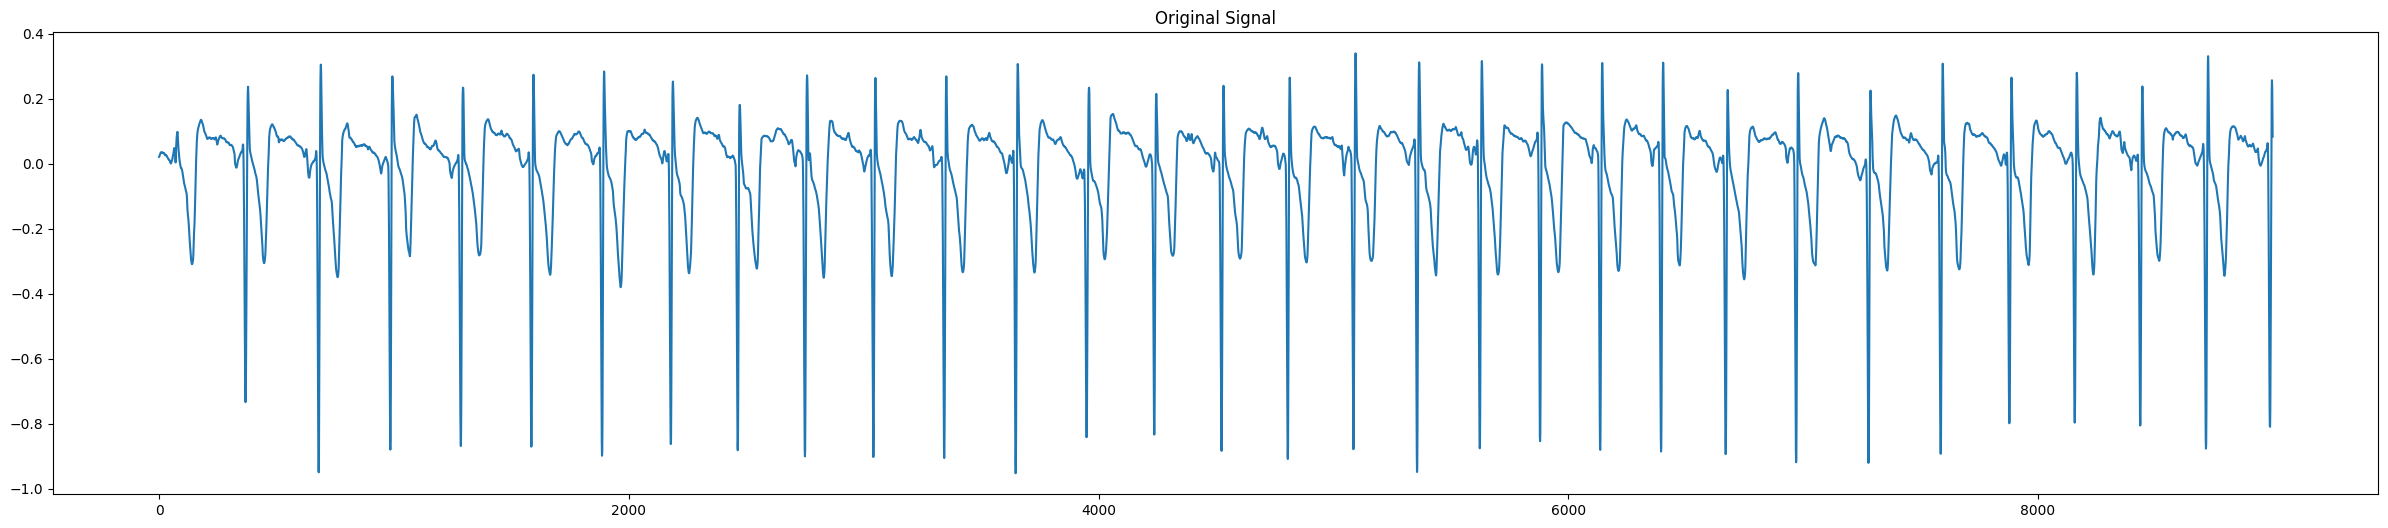

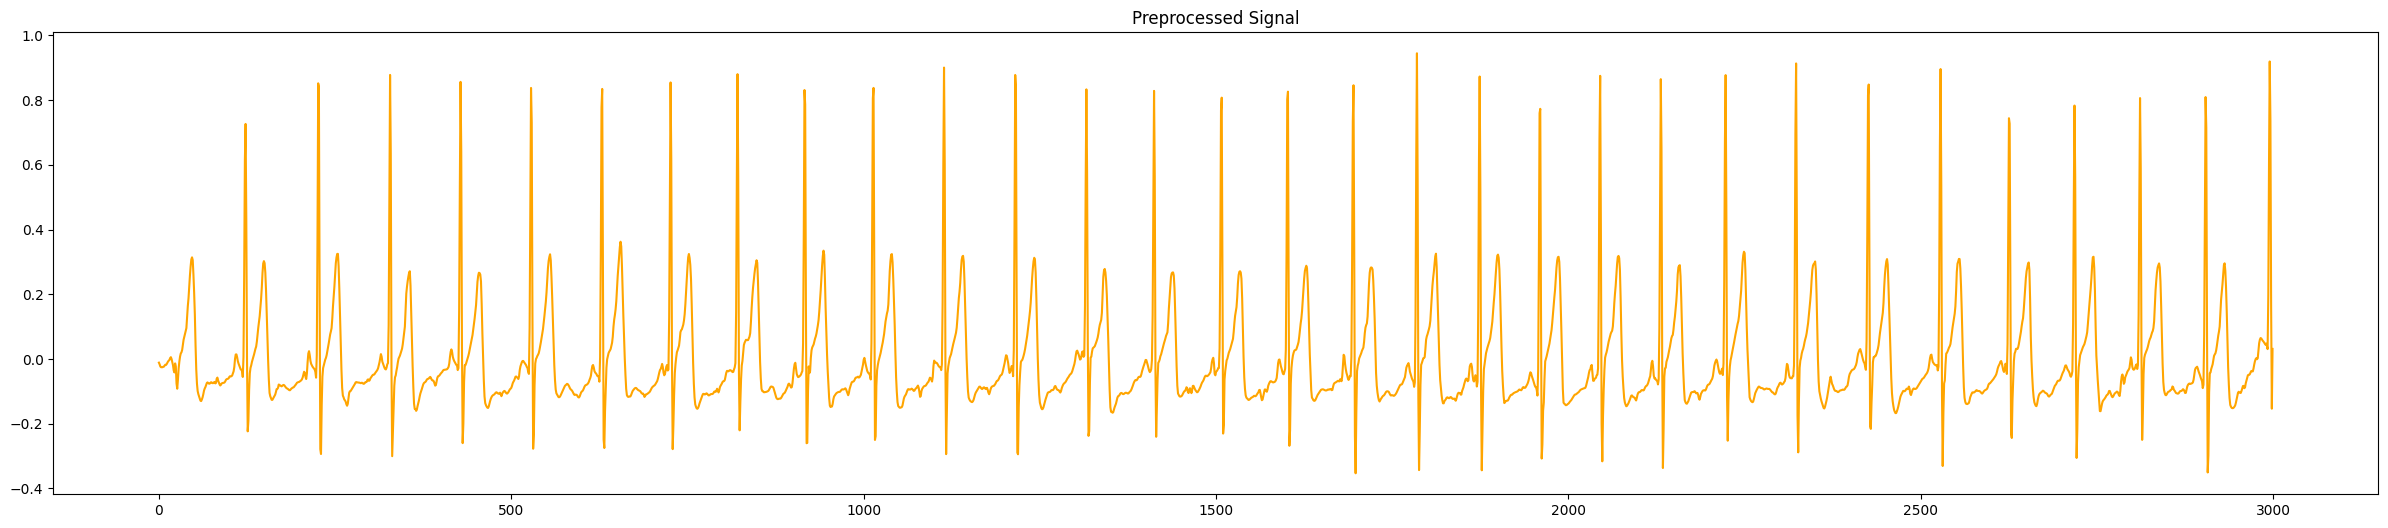

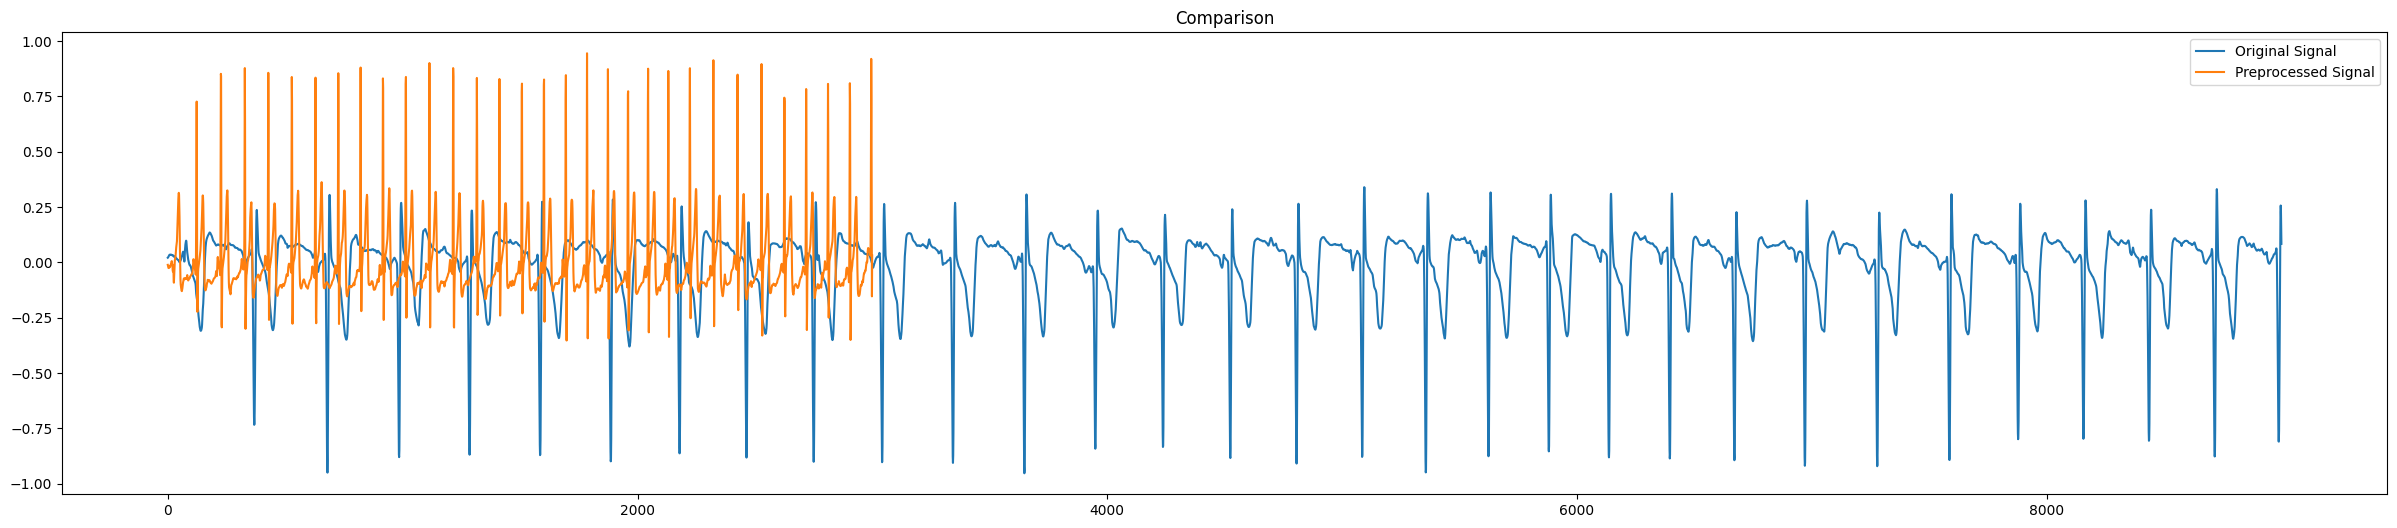

In [4]:
import matplotlib.pyplot as plt

signal, _ = wfdb.rdsamp(src_dir / "A00007")
signal = np.squeeze(signal)
signal_p = np.loadtxt(dst_dir / "A00007.csv")

plt.figure(figsize=(30, 6))
plt.plot(signal, label="")
plt.title("Original Signal")
plt.show()

plt.figure(figsize=(30, 6))
plt.plot(signal_p, label="", color="orange")
plt.title("Preprocessed Signal")
plt.show()

plt.figure(figsize=(30, 6))
plt.plot(signal, label="Original Signal")
plt.plot(signal_p, label="Preprocessed Signal")
plt.title("Comparison")
plt.legend()
plt.show()